### Instructions
 * The research question is can we use algorithms and compute to identify clothing items? Specifically, can we determine which algorithm and compute methodology provides us the most efficient approach for classifying simple fashion images?
 * Using the base samples available from Zalando Research:
  * https://github.com/zalandoresearch/fashion-mnist
  * Review the data -- clean as appropriate
  * Provide an initial data analysis
 * Implement at least two approaches for classifying the digits -- examples below:
  * Naïve bayes
  * Neural Networks
  * Keras
  * Azure ML
  * IBM DSX
  * Boosted trees
  * Linear classification
  * Your choice

* Answer the following questions:
  * What is the accuracy of each method?
  * What are the trade-offs of each approach?
  * What is the compute performance of each approach

## Importing Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# -----------------------------------
import tensorflow as tf
import keras
from tensorflow import keras
import keras_tuner as kt

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# !pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.6 MB/s eta 0:00:00


# TensorFlow Keras Model

## Building Keras Model

### Reading in the data, Splitting data into Training/Testing datasets, and reshapping the images

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
train_images  = train_images / 255.0
test_images = test_images / 255.0

### Printing some examples of the clothing data

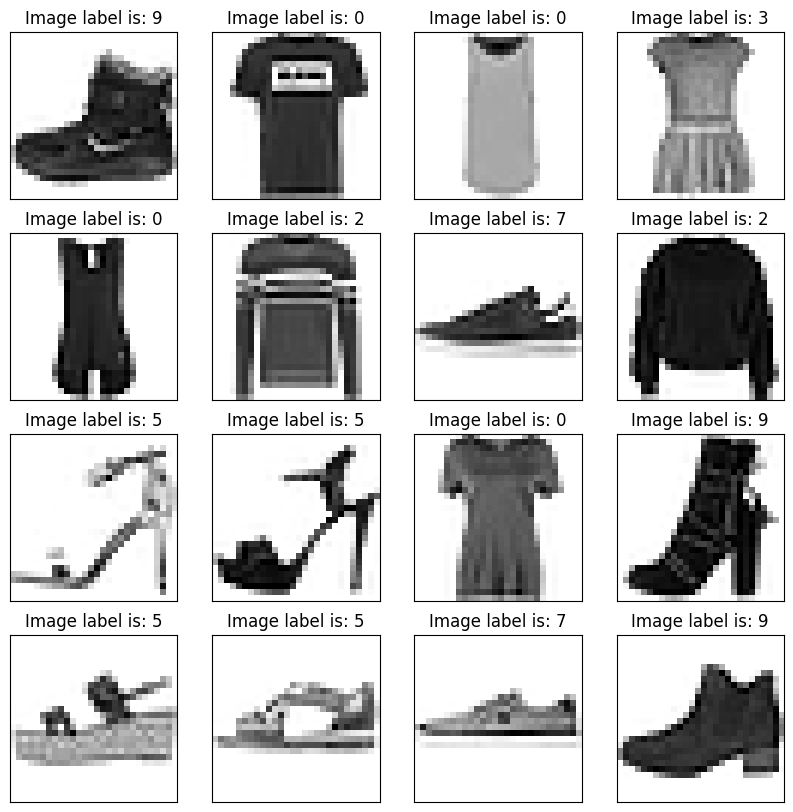

In [6]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(train_labels[i]))
plt.show()

In [7]:
x_train = train_images.reshape(-1,28,28,1)
x_test = test_images.reshape(-1,28,28,1)

### Hyperparameter Tuning and Building Keras Model

For hypertuning the Keras model I am using Keras Tuner which is a TensorFlow library that helps you pick the optimal set of hyperparameters. Additional information and documentation over the Keras Tuner library [here](https://www.tensorflow.org/tutorials/keras/keras_tuner).

In [9]:
## Setting the parameters for the model to
def build_model(hp):
    model = keras.Sequential([

    # First conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_1_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
        activation='relu',
        input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),

    # Second conv_block
    keras.layers.Conv2D(
        filters = hp.Choice('conv_2_filter', values=[16, 32, 64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
        activation='relu'),
    keras.layers.MaxPooling2D((2,2)),

    # --------------------------------
    keras.layers.Flatten(),
    keras.layers.Dense(units = hp.Choice('units', values=[16, 32, 64, 128, 256]),
                       activation='relu'),
    keras.layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),

    # --------------------------------
    keras.layers.Dense(10)
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',
                                                            values=[1e-1, 1e-2, 1e-3, 1e-4])),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

### Using the [Hyperband](https://www.tensorflow.org/tutorials/keras/keras_tuner#:~:text=The%20Hyperband%20tuning%20algorithm%20uses%20adaptive%20resource%20allocation%20and%20early%2Dstopping%20to%20quickly%20converge%20on%20a%20high%2Dperforming%20model.) tuning algorithm to find the optimal parameters.

In [10]:
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     hyperband_iterations=3)

In [11]:
##The combination of parameters that the Hyperband tuning algorithm will run through
tuner.search_space_summary()

Search space summary
Default search space size: 7
conv_1_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
conv_2_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


[EarlyStopping](https://keras.io/api/callbacks/early_stopping/) in Keras allows us to stop training the model early if the model stops improving.

In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

The following code runs through all possible model combinations as specified in the build_model function above.

**Note:** Keras Tuner took over 2 hours for the following code block to run, but I also left out the "early_stop" arguement, which may have allowed it to end sooner.

In [12]:
tuner.search(x_train,train_labels, epochs=3, validation_split=0.2, callbacks=[early_stop])

Trial 30 Complete [00h 09m 23s]
val_accuracy: 0.8678333163261414

Best val_accuracy So Far: 0.9058333039283752
Total elapsed time: 02h 14m 51s


### Optimal Hyperparameters generated from the Keras Search

In [34]:
best_hps = best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""conv_1_filter is {best_hps.get('conv_1_filter')}""")
print(f"""conv_1_kernel is {best_hps.get('conv_1_kernel')}""")
print(f"""conv_2_filter is {best_hps.get('conv_2_filter')}""")
print(f"""conv_2_kernel is {best_hps.get('conv_2_kernel')}""")
print("-------------------------------------------------")
print(f"""units is {best_hps.get('units')}""")
print(f"""learning_rate is {best_hps.get('learning_rate')}""")
print(f"""dropout is {best_hps.get('dropout')}""")
print("-------------------------------------------------")
print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected layer
is {best_hps.get('units')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.""")

conv_1_filter is 16
conv_1_kernel is 4
conv_2_filter is 128
conv_2_kernel is 3
-------------------------------------------------
units is 256
learning_rate is 0.001
dropout is 0.30000000000000004
-------------------------------------------------
The hyperparameter search is complete. The optimal number of units in the first densely-connected layer 
is 256 and the optimal learning rate for the optimizer is 0.001.


## Training Keras Model

In [15]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 128)       18560     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dense_4 (Dense)             (None, 256)              

In [17]:
##Now that we have the optimal hyperparamters for the model and data, we can use these to train and build the model.
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, train_labels, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
1500/1500 [==============================] - 58s 38ms/step - loss: 0.4777 - accuracy: 0.8278 - val_loss: 0.3369 - val_accuracy: 0.8747
Epoch 2/10
1500/1500 [==============================] - 59s 39ms/step - loss: 0.3195 - accuracy: 0.8814 - val_loss: 0.2832 - val_accuracy: 0.8966
Epoch 3/10
1500/1500 [==============================] - 57s 38ms/step - loss: 0.2726 - accuracy: 0.9004 - val_loss: 0.2890 - val_accuracy: 0.8954
Epoch 4/10
1500/1500 [==============================] - 56s 38ms/step - loss: 0.2382 - accuracy: 0.9120 - val_loss: 0.2583 - val_accuracy: 0.9065
Epoch 5/10
1500/1500 [==============================] - 56s 38ms/step - loss: 0.2134 - accuracy: 0.9213 - val_loss: 0.2557 - val_accuracy: 0.9063
Epoch 6/10
1500/1500 [==============================] - 59s 39ms/step - loss: 0.1877 - accuracy: 0.9293 - val_loss: 0.2472 - val_accuracy: 0.9150
Epoch 7/10
1500/1500 [==============================] - 59s 39ms/step - loss: 0.1693 - accuracy: 0.9370 - val_loss: 0.2539 -

In [18]:
##Running the model with the optimal hyperparameters
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(x_train, train_labels,
                         epochs=best_epoch,
                         validation_split=0.2,
                         callbacks=[early_stop])

Epoch 1/10
1500/1500 [==============================] - 58s 38ms/step - loss: 0.4762 - accuracy: 0.8295 - val_loss: 0.3469 - val_accuracy: 0.8730
Epoch 2/10
1500/1500 [==============================] - 59s 39ms/step - loss: 0.3163 - accuracy: 0.8827 - val_loss: 0.2913 - val_accuracy: 0.8908
Epoch 3/10
1500/1500 [==============================] - 56s 38ms/step - loss: 0.2707 - accuracy: 0.9009 - val_loss: 0.2658 - val_accuracy: 0.9027
Epoch 4/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.2405 - accuracy: 0.9101 - val_loss: 0.2482 - val_accuracy: 0.9100
Epoch 5/10
1500/1500 [==============================] - 56s 38ms/step - loss: 0.2125 - accuracy: 0.9215 - val_loss: 0.2463 - val_accuracy: 0.9115
Epoch 6/10
1500/1500 [==============================] - 57s 38ms/step - loss: 0.1912 - accuracy: 0.9280 - val_loss: 0.2459 - val_accuracy: 0.9128
Epoch 7/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.1714 - accuracy: 0.9366 - val_loss: 0.2510 -

### Model Structure and Summary

In [19]:
hypermodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 25, 25, 16)        272       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 128)       18560     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3200)              0         
                                                                 
 dense_10 (Dense)            (None, 256)              

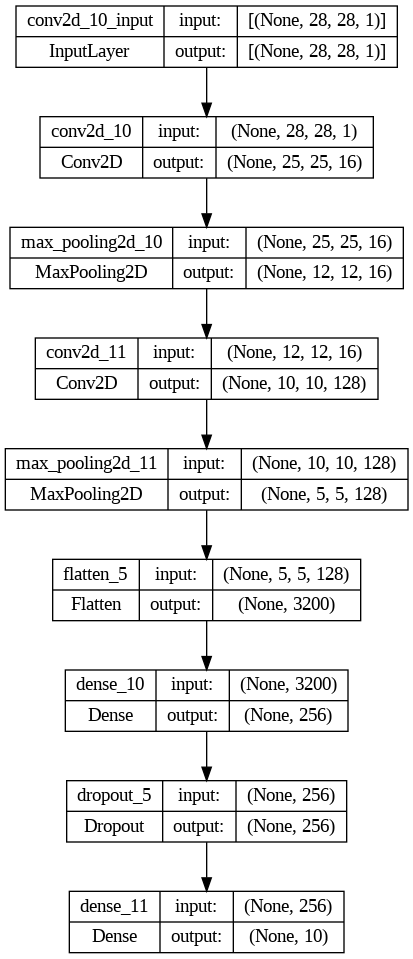

In [20]:
##Plot of the layers from the optimal hypermodel
keras.utils.plot_model(hypermodel, show_shapes=True)

## Keras Model Evaluation and Performance

In [22]:
pred = hypermodel.predict(x_test)

print("Prediction is -> {}".format(pred[12]))
print("Actual value is -> {}".format(test_labels[12]))
print("The highest value for label is {}".format(np.argmax(pred[12])))

313/313 [==============================] - 5s 15ms/step
Prediction is -> [ -6.9891524  -10.122569   -12.728591    -5.5977297  -13.770471
   4.547144   -13.319708     4.337918     2.1259847    0.08639867]
Actual value is -> 7
The highest value for label is 5


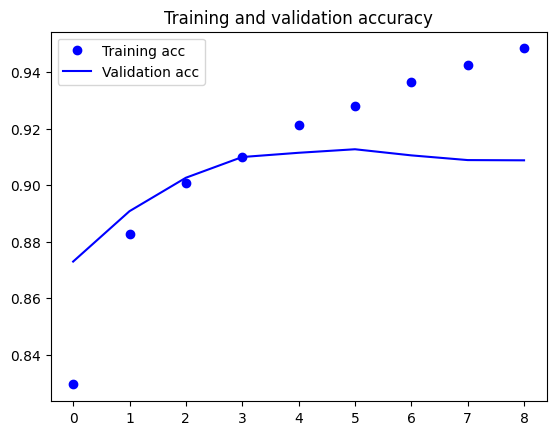

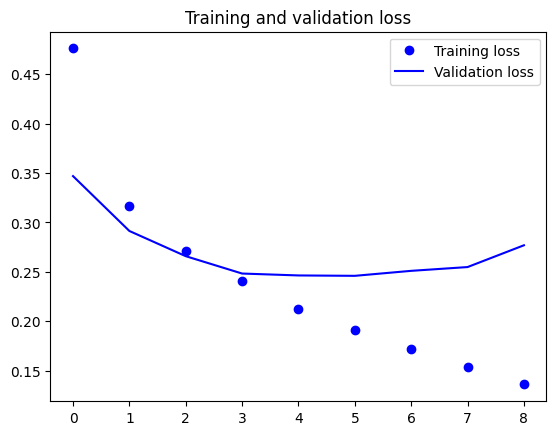

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The Validation/Test data does not seem to have as good of accuracy as the Training dataset had. However, for the the sake of time I reduced the number of Epochs for the Test dataset from 50 to 10, which might have reduced the chances for the model the improve further.

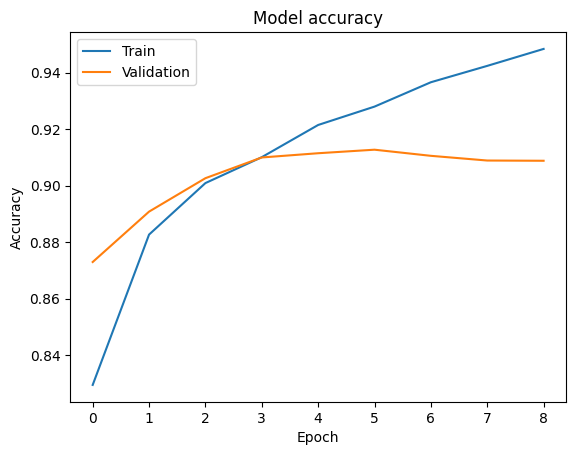

In [24]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The Keras Model with Hyperparameter Tuning did produce fairly good results, with an Accuracy on the test images of 90.24%. However, using the Keras Search function to find the optimal parameters did take over 2 hours to find, which seems to be pretty computationally heavy for the accuracy received.

In [32]:
eval_result = hypermodel.evaluate(x_test, test_labels)
print("test loss:", f"{eval_result[0]:.2%}")
print("test accuracy:", f"{eval_result[1]:.2%}")

313/313 [==============================] - 3s 8ms/step - loss: 0.3013 - accuracy: 0.9024
test loss: 30.13%
test accuracy: 90.24%
